In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
from warnings import filterwarnings
import matplotlib.pyplot as plt
filterwarnings('ignore')
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('C:\\GaTech\\Ph. D\\Research\\Datasets\\metabolomic_data.csv')
drug_data = pd.read_csv('C:\\GaTech\\Ph. D\\Research\\Datasets\\sanger-dose-response.csv')
metadata = pd.read_csv('C:\\GaTech\\Ph. D\\Research\\Datasets\\sample_info.csv')

In [3]:
data.head(2)

,CCLE_ID,DepMap_ID,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,...,C56:8 TAG,C56:7 TAG,C56:6 TAG,C56:5 TAG,C56:4 TAG,C56:3 TAG,C56:2 TAG,C58:8 TAG,C58:7 TAG,C58:6 TAG
0,DMS53_LUNG,ACH-000698,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,...,6.070239,6.133433,6.091089,6.257711,6.372732,6.202511,5.939576,6.309821,6.115974,5.999436
1,SW1116_LARGE_INTESTINE,ACH-000489,5.577413,5.727045,5.111468,6.073250,5.802494,5.824473,5.888821,5.768379,...,6.248653,6.633575,6.378052,6.341043,6.360945,6.333540,6.137271,7.065858,6.832174,6.363064


In [4]:
drug_data.head(2)

,DATASET,COSMIC_ID,DRUG_ID,MIN_CONC,MAX_CONC,RMSE_PUBLISHED,Z_SCORE_PUBLISHED,IC50_PUBLISHED,AUC_PUBLISHED,ARXSPAN_ID,DRUG_NAME,BROAD_ID,upper_limit,ec50,slope,lower_limit,auc,log2.ic50,mse,R2
0,GDSC1,683665,1,0.007813,2.0,0.022518,-0.192056,10.977393,0.982116,ACH-002270,ERLOTINIB,BRD-K70401845,0.992788,2.839376,-5.670993,0.514389,0.990834,NaN,0.000034,0.904675
1,GDSC1,684055,1,0.007813,2.0,0.031831,0.505823,23.133991,0.984820,ACH-002104,ERLOTINIB,BRD-K70401845,1.006405,0.028649,-0.186377,0.990054,0.997138,NaN,0.000057,0.028903


In [5]:
metadata.head(2)

,DepMap_ID,stripped_cell_line_name,CCLE_Name,alias,COSMIC_ID,lineage,lineage_subtype,lineage_sub_subtype,lineage_molecular_subtype,sex,...,culture_medium,cas9_activity,RRID,sample_collection_site,primary_or_metastasis,disease,disease_subtype,age,Sanger_model_ID,additional_info
0,ACH-000001,NIHOVCAR3,NIHOVCAR3_OVARY,OVCAR3,905933.0,ovary,ovary_adenocarcinoma,high_grade_serous,NaN,Female,...,NaN,NaN,CVCL_0465,ascites,Metastasis,Ovarian Cancer,"Adenocarcinoma, high grade serous",60.0,SIDM00105,NaN
1,ACH-000002,HL60,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,905938.0,blood,AML,M3,NaN,Female,...,NaN,NaN,CVCL_0002,haematopoietic_and_lymphoid_tissue,Primary,Leukemia,"Acute Myelogenous Leukemia (AML), M3 (Promyelo...",35.0,SIDM00829,NaN


In [6]:
drug_data.rename(columns = {'ARXSPAN_ID': 'DepMap_ID'}, inplace=True)
wd = data.merge(drug_data, on='DepMap_ID')
wd = wd.merge(metadata, on='DepMap_ID')
wd.head(2)

,CCLE_ID,DepMap_ID,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,...,culture_medium,cas9_activity,RRID,sample_collection_site,primary_or_metastasis,disease,disease_subtype,age,Sanger_model_ID,additional_info
0,DMS53_LUNG,ACH-000698,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,...,RPMI; 10% FBS,25,CVCL_1177,lung,Primary,Lung Cancer,Small Cell Lung Cancer (SCLC),54.0,SIDM00523,NaN
1,DMS53_LUNG,ACH-000698,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,...,RPMI; 10% FBS,25,CVCL_1177,lung,Primary,Lung Cancer,Small Cell Lung Cancer (SCLC),54.0,SIDM00523,NaN


In [7]:
wd.shape

(251886, 269)

In [8]:
wd = wd[(wd['DRUG_NAME'] == 'GEMCITABINE') & (wd['DATASET'] == 'GDSC2')]
wd.reset_index(inplace=True, drop=True)
wd.head(2)

,CCLE_ID,DepMap_ID,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,...,culture_medium,cas9_activity,RRID,sample_collection_site,primary_or_metastasis,disease,disease_subtype,age,Sanger_model_ID,additional_info
0,DMS53_LUNG,ACH-000698,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,...,RPMI; 10% FBS,25,CVCL_1177,lung,Primary,Lung Cancer,Small Cell Lung Cancer (SCLC),54.0,SIDM00523,NaN
1,SW1116_LARGE_INTESTINE,ACH-000489,5.577413,5.727045,5.111468,6.073250,5.802494,5.824473,5.888821,5.768379,...,NaN,NaN,CVCL_0544,Colon,Primary,Colon/Colorectal Cancer,Adenocarcinoma,73.0,SIDM00835,NaN


In [9]:
y = wd.pop('IC50_PUBLISHED')
y

0       5.526728
1      50.762353
2       0.080245
3       0.091665
4       0.039051
         ...    
516     7.038239
517    65.167573
518     0.123894
519     0.030070
520    17.442295
Name: IC50_PUBLISHED, Length: 521, dtype: float64

In [10]:
y = pd.Series(y)

In [11]:
wd = wd[data.columns]

In [12]:
X = wd.select_dtypes('float64')
X.head(2)

,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,AMP,citrate,...,C56:8 TAG,C56:7 TAG,C56:6 TAG,C56:5 TAG,C56:4 TAG,C56:3 TAG,C56:2 TAG,C58:8 TAG,C58:7 TAG,C58:6 TAG
0,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,5.923737,5.641242,...,6.070239,6.133433,6.091089,6.257711,6.372732,6.202511,5.939576,6.309821,6.115974,5.999436
1,5.577413,5.727045,5.111468,6.073250,5.802494,5.824473,5.888821,5.768379,5.760784,5.914742,...,6.248653,6.633575,6.378052,6.341043,6.360945,6.333540,6.137271,7.065858,6.832174,6.363064


In [13]:
X = pd.DataFrame(data = MinMaxScaler().fit_transform(X), columns = X.columns)
X.head(2)

,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,AMP,citrate,...,C56:8 TAG,C56:7 TAG,C56:6 TAG,C56:5 TAG,C56:4 TAG,C56:3 TAG,C56:2 TAG,C58:8 TAG,C58:7 TAG,C58:6 TAG
0,0.495307,0.621262,0.510802,0.459783,0.452734,0.380599,0.587679,0.438061,0.405262,0.488794,...,0.599608,0.527663,0.491753,0.599994,0.609317,0.650514,0.463536,0.569028,0.516410,0.512918
1,0.270433,0.454296,0.237895,0.491937,0.590912,0.363184,0.521658,0.473832,0.353421,0.633582,...,0.680131,0.743575,0.626599,0.635141,0.604739,0.714077,0.558885,0.866371,0.742402,0.637727


In [14]:
labels = []
for i in list(y):
    if i > 10.00:
        labels.append('NR')
    else:
        labels.append('R')
y = pd.Series(labels)

In [15]:
y

0       R
1      NR
2       R
3       R
4       R
       ..
516     R
517    NR
518     R
519     R
520    NR
Length: 521, dtype: object

In [16]:
y.value_counts()

R     374
NR    147
dtype: int64

In [17]:
y.shape, X.shape

((521,), (521, 225))

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = pd.Series(le.fit_transform(y))
y.value_counts()

1    374
0    147
dtype: int64

In [19]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [20]:
y.value_counts()

1    374
0    374
dtype: int64

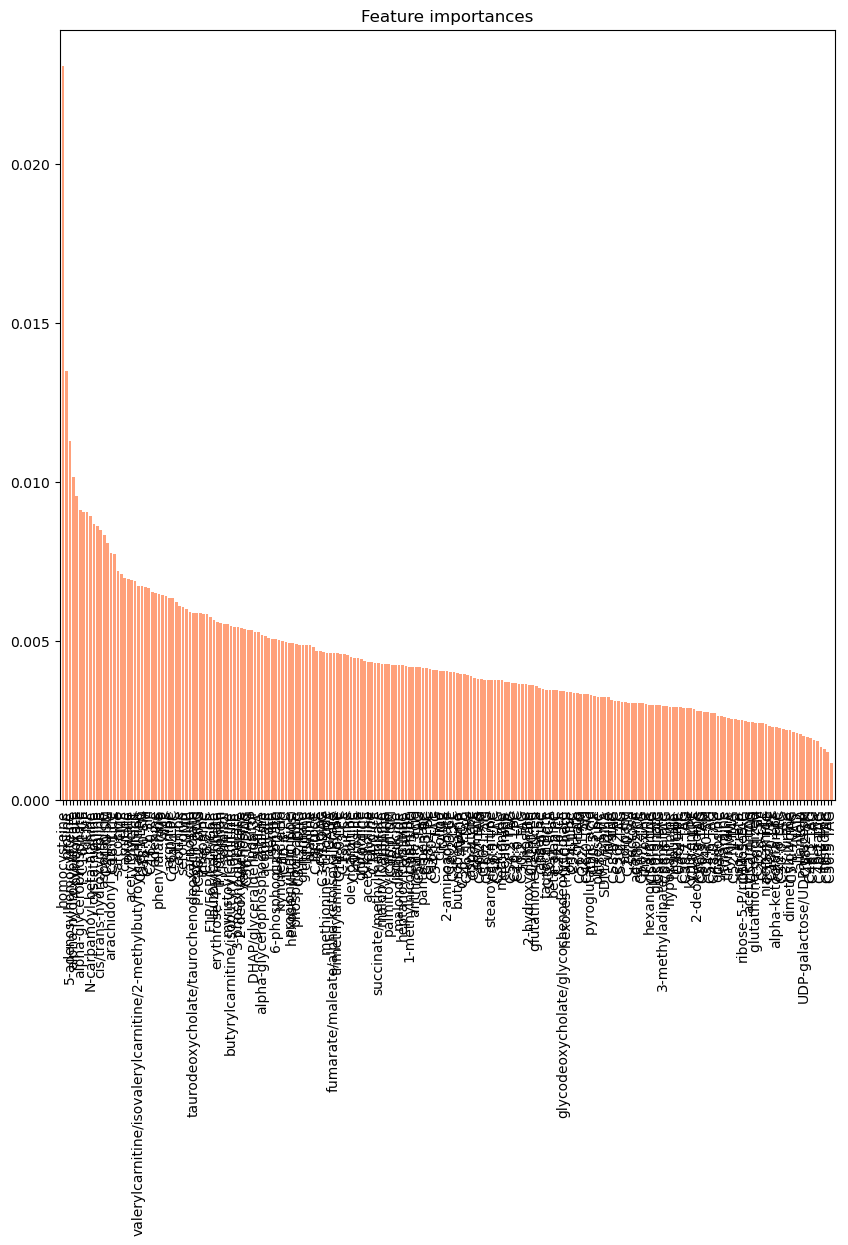

In [21]:
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state = 43)

model = RandomForestClassifier(class_weight = 'balanced', n_estimators = 150, random_state = 43)
model.fit(X_train, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (10,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="lightsalmon", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [22]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report

sfm = SelectFromModel(model, threshold = 0.010)
sfm.fit(X_train, y_train)

X_train_transformed = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(0)])
X_test_transformed = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(0)])

model.fit(X_train_transformed, y_train)
prediction = model.predict_proba(X_test_transformed)[:, 1]
y_pred = model.predict(X_test_transformed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.74      0.73       113
           1       0.73      0.70      0.71       112

    accuracy                           0.72       225
   macro avg       0.72      0.72      0.72       225
weighted avg       0.72      0.72      0.72       225



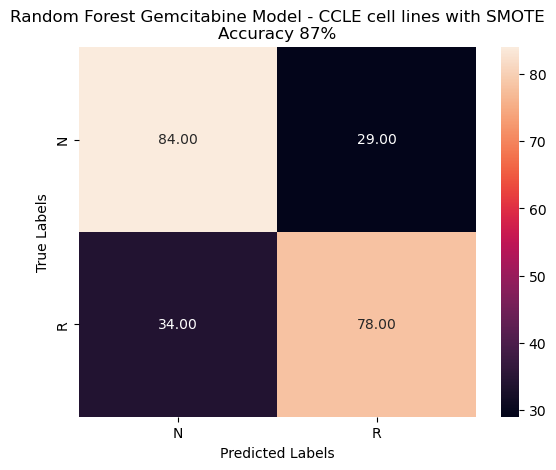

In [23]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels = ['N', 'R'], yticklabels = ['N', 'R'], fmt='.2f')
ax.set_title('Random Forest Gemcitabine Model - CCLE cell lines with SMOTE\nAccuracy 87%')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

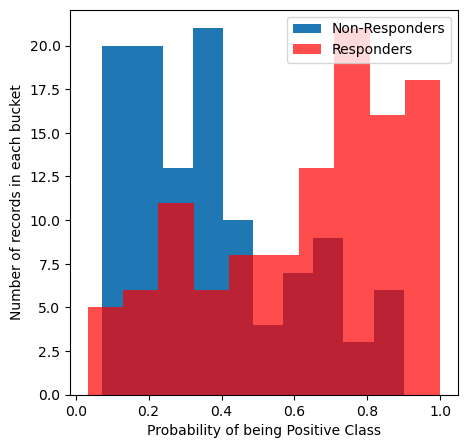

In [24]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders')
plt.hist(prediction[y_test==1], label='Responders', alpha=0.7, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [25]:
len(X_train_transformed.columns)

4

In [26]:
model2 = SVC(kernel = 'linear', C=1, gamma='auto', probability = True)
model2.fit(X_train_transformed, y_train)
prediction2 = model2.predict_proba(X_test_transformed)[:, 1]
y_pred = model2.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.80      0.69       113
           1       0.71      0.49      0.58       112

    accuracy                           0.64       225
   macro avg       0.66      0.64      0.64       225
weighted avg       0.66      0.64      0.64       225



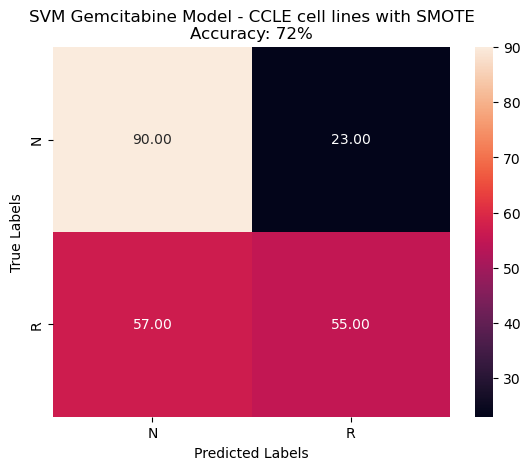

In [27]:
fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, xticklabels = ['N', 'R'], yticklabels = ['N', 'R'], fmt='.2f')
ax.set_title('SVM Gemcitabine Model - CCLE cell lines with SMOTE\nAccuracy: 72%')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

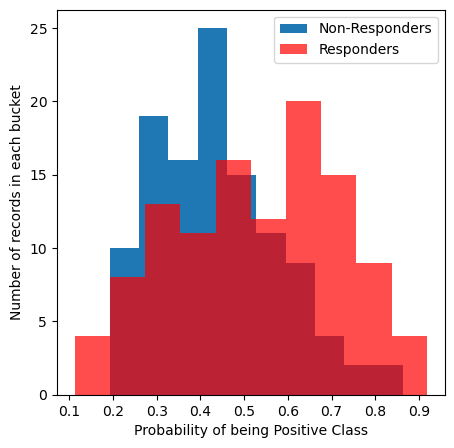

In [28]:
plt.figure(figsize=(5, 5))
plt.hist(prediction2[y_test==0], label='Non-Responders')
plt.hist(prediction2[y_test==1], label='Responders', alpha=0.7, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [29]:
model3 = XGBClassifier()
model3.fit(X_train_transformed, y_train)
prediction3 = model3.predict_proba(X_test_transformed)[:,1]
y_pred = model3.predict(X_test_transformed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71       113
           1       0.70      0.71      0.71       112

    accuracy                           0.71       225
   macro avg       0.71      0.71      0.71       225
weighted avg       0.71      0.71      0.71       225



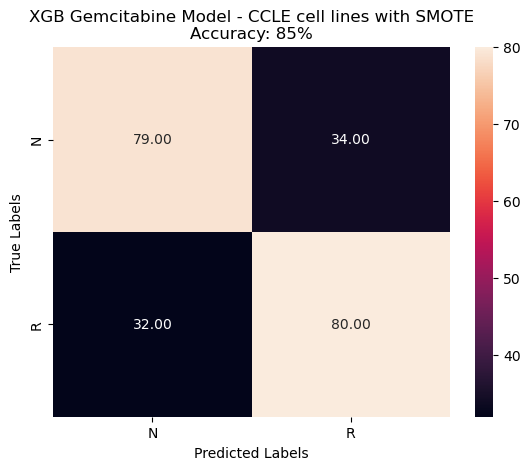

In [30]:
fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, xticklabels = ['N', 'R'], yticklabels = ['N', 'R'], fmt='.2f')
ax.set_title('XGB Gemcitabine Model - CCLE cell lines with SMOTE\nAccuracy: 85%')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

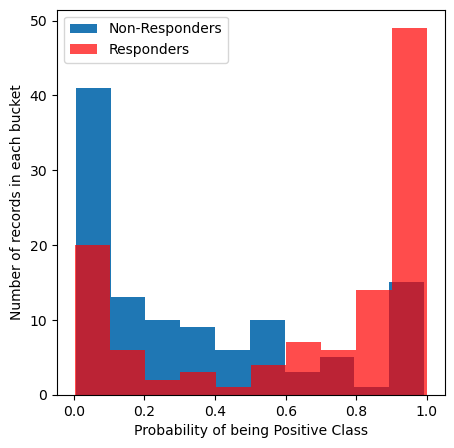

In [31]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders')
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.7, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [32]:
y_train.shape

(523,)

In [33]:
y_test.shape

(225,)

In [34]:
unique, counts = np.unique(y_train, return_counts=True)

In [35]:
dict(zip(unique, counts))

{0: 261, 1: 262}

In [36]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 113, 1: 112}